# Underperformance detection

In this notebook, we explore a self-supervised approach for the underperformance use-case. Given a time series comprising measurements from a turbine including power output and dependent parameters like wind speed and rotor speed, we i) distinguish between periods of underperformance and periods of optimal performance using an unsupervised method, and ii) we use those periods to train a classifier which can be then tested in new data.

To evaluate our approach, we compare our output with the ground-truth information, where we assume that we have underperformance if and only if the static yaw angle (which is provided) is non-zero.

In [1]:
import os, sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from modules.preprocessing import *
from modules.io import *

#from modules.patterns import *
#from modules.statistics import *
#from modules.plots import *
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from tqdm.notebook import tqdm
import seaborn
import pickle
from copy import deepcopy
from timeit import default_timer as timer
from sklearn.ensemble import RandomForestRegressor as RFRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics
from feature_selection_config import FeatureSelectionConf as FSConf
from sklearn.pipeline import Pipeline
import lightgbm as lgb
plt.style.use('ggplot')
from sklearn.linear_model import QuantileRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from underperformance_estimator import UnderperformanceEstimator 
from sklearn.metrics import accuracy_score


# Load Data and apply filters
We read three data files: BEBEZE01, BEBEZE02, BEBEZE03. We apply filters to remove outliers. We also calculate the dynamic yaw misalignment.

Data from turbine 1/BEBEZE01.csv loaded.
Data from turbine 2/BEBEZE02.csv loaded.
Data from turbine 3/BEBEZE03.csv loaded.
after iqr
(43492, 212)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
(14205, 212)


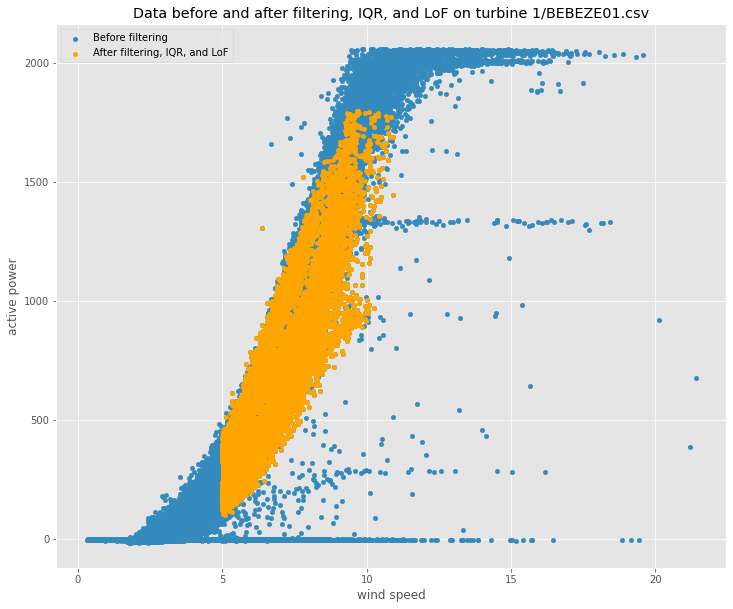

after iqr
(43404, 212)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
(13977, 212)


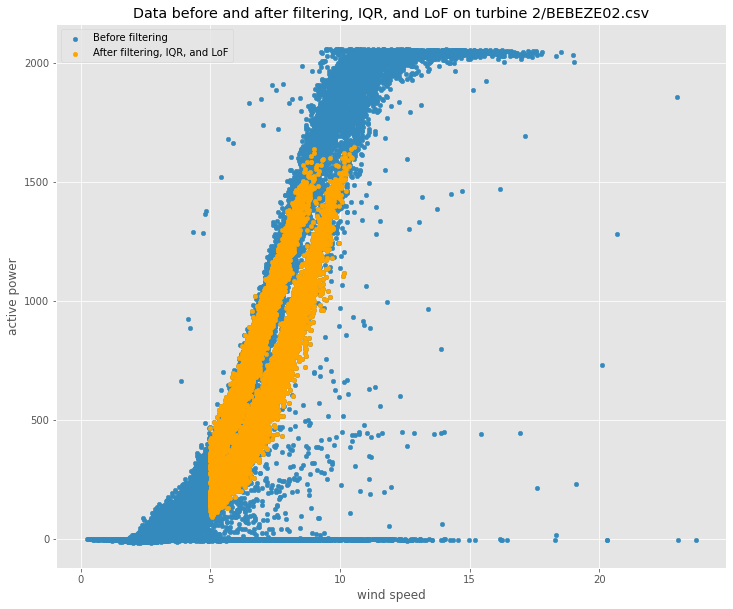

after iqr
(43979, 212)
Filter Complete
Filter Complete
Filter Complete
Filter Complete
(14620, 212)


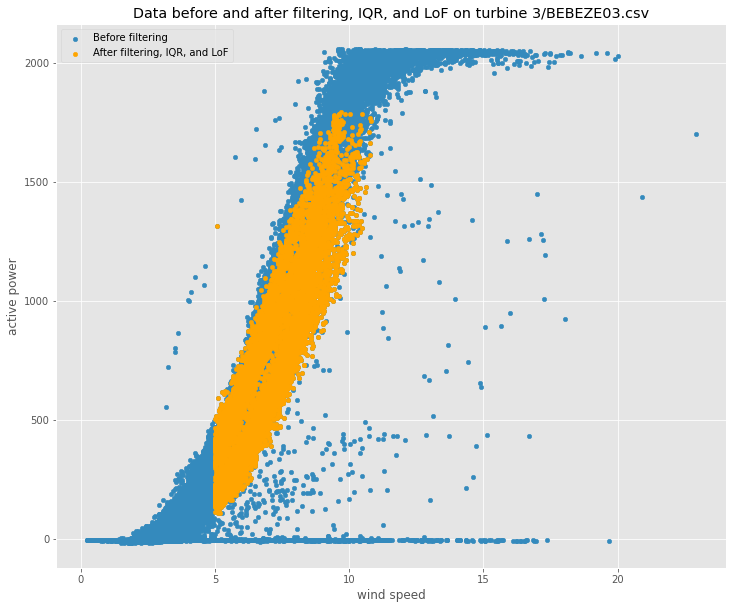

In [2]:
turbines = [f'/data/data2/BBZ_10min_Scada/BEBEZE01.csv', '/data/data2/BBZ_10min_Scada/BEBEZE02.csv', '/data/data2/BBZ_10min_Scada/BEBEZE03.csv']
df_dict = {}

col_names = ['WindSpeed_avg', 'BladeAngle_avg', 'RotorSpeed_avg', 'ActivePower_avg',
             'NacellePosition_avg', 'AbsWindDirection_avg']
            
            
for i, t in enumerate(turbines):
    dataset_file = t
    df_temp = load_df(dataset_file)
    df_temp = df_temp.dropna(axis=1, how='all')
    df_temp = df_temp[col_names + [c for c in df_temp.columns if c not in col_names]]
    df_temp.date = pd.to_datetime(df_temp.date)
    df_temp = df_temp.set_index(df_temp.date)
    df_temp = df_temp.drop(['date'], axis=1)
    cols = ['wind speed', 'pitch angle', 'rotor speed', 'active power',
            'nacelle direction', 'wind direction'] # rename
    
    df_temp.columns = cols + list(df_temp.columns[len(cols):])
#     df_temp = df_temp.loc[:,df_temp.apply(pd.Series.nunique) != 1]
    key = f"{i+1}/" + os.path.basename(t)
    df_dict[key] = df_temp
    print(f"Data from turbine {key} loaded.")

for t, df in df_dict.items():
    df["theta_d"] = (df['wind direction'] - df['nacelle direction']) % 360
    df["theta_d"][df["theta_d"] > +180] -= 360
    df["theta_d"][df["theta_d"] < -180] += 360
    df["theta_d"] = df["theta_d"].rolling(6).mean()
    df = df.dropna()

    df_initial = df.copy()

    # Perform IQR outlier removal
    df_iqr = outliers_IQR(df[cols])
    df = df.loc[df_iqr.index]
    print('after iqr')
    print(df.shape)

    # drop values of wind speed under 5m/s
    df=filter_col(df, 0, less_than=5, bigger_than=11)

    # drop values with pitch angle higher than 2 degrees or lower than -2 degrees
    df=filter_col(df, 1, less_than=-2, bigger_than=2)

    # drop values of rotor speed under 8rpm
    df=filter_col(df, 2, less_than=8, bigger_than=15)

    # drop values of power near the power_limit and near or below zero
    
    power_limit = 2050
    df=filter_col(df, 3, less_than=1e-4, bigger_than= power_limit)


    # Keep only dates with lidar measurements
    start = '2018-06-02'
    end = '2019-01-11'
    df = filter_dates(df, start, end)
    
    # Remove Outliers using LoF
    # df = outliers_LoF(df).copy()
    
    # Add resulting dataframe to the dict of all dataframes
    print(df.shape)
    df_dict[t] = df
    
    # Uncomment for plots
    ax1=df_initial.plot.scatter(x='wind speed', y='active power', figsize=(12, 10), label='Before filtering')
    df.plot.scatter(ax=ax1, x='wind speed', y='active power', c='orange', label = 'After filtering, IQR, and LoF')
    plt.title(f"Data before and after filtering, IQR, and LoF on turbine {t}")
    plt.show()

In [3]:
df_dict['1/BEBEZE01.csv'].describe()

,wind speed,pitch angle,rotor speed,active power,nacelle direction,wind direction,AbsWindDirection_max,AbsWindDirection_min,AbsWindDirection_std,ActivePower_max,...,WindSpeed_2_avg,WindSpeed_2_max,WindSpeed_2_min,WindSpeed_2_std,WindSpeed_2_turbInt,WindSpeed_max,WindSpeed_min,WindSpeed_std,WindSpeed_turbInt,theta_d
count,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,...,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000,14205.000000
mean,6.707977,0.155026,11.258660,624.082492,196.863144,194.320173,186.558679,199.605383,10.007576,941.731190,...,6.797040,9.069511,4.595661,0.817554,12.077335,8.870570,4.629065,0.775895,11.596600,0.220878
std,1.222293,0.303553,1.636826,353.173880,96.696316,96.974235,100.560863,89.469217,12.981063,547.250455,...,1.262332,1.760827,1.105137,0.331188,4.462535,1.704609,1.080591,0.319719,4.354018,5.755549
min,5.000000,0.000000,8.170000,102.930000,0.120000,0.010000,0.020000,0.080000,3.730000,128.090000,...,4.820000,5.760000,1.110000,0.210000,3.280000,5.570000,1.300000,0.180000,2.880000,-48.406667
25%,5.700000,0.000000,10.210000,342.840000,152.680000,151.620000,86.530000,147.580000,7.200000,516.340000,...,5.760000,7.680000,3.820000,0.560000,8.590000,7.530000,3.870000,0.520000,8.190000,-3.231667
50%,6.480000,0.000000,10.700000,533.590000,207.550000,204.500000,209.610000,195.830000,8.770000,779.550000,...,6.570000,8.760000,4.480000,0.780000,11.810000,8.590000,4.510000,0.740000,11.380000,-0.003333
75%,7.510000,0.160000,12.330000,836.480000,256.480000,253.500000,263.160000,262.110000,10.530000,1253.770000,...,7.630000,10.300000,5.240000,1.030000,14.940000,10.050000,5.260000,0.980000,14.420000,3.495000
max,10.920000,2.000000,15.000000,1799.750000,359.990000,360.000000,359.960000,359.990000,521.670000,2157.300000,...,11.370000,18.350000,9.620000,2.640000,37.030000,18.190000,9.460000,2.580000,36.340000,105.420000


### Read static yaw misalignment and create underperformance labels
We create a new column, named 'perf', which contains binary information as follows: if the static yaw angle is larger than 0 then 'perf' is 0, and otherwise 'perf' is 1. 


Static Yaw angles: [-6.7, 4.8, 9.4, 0.0, 0.0]


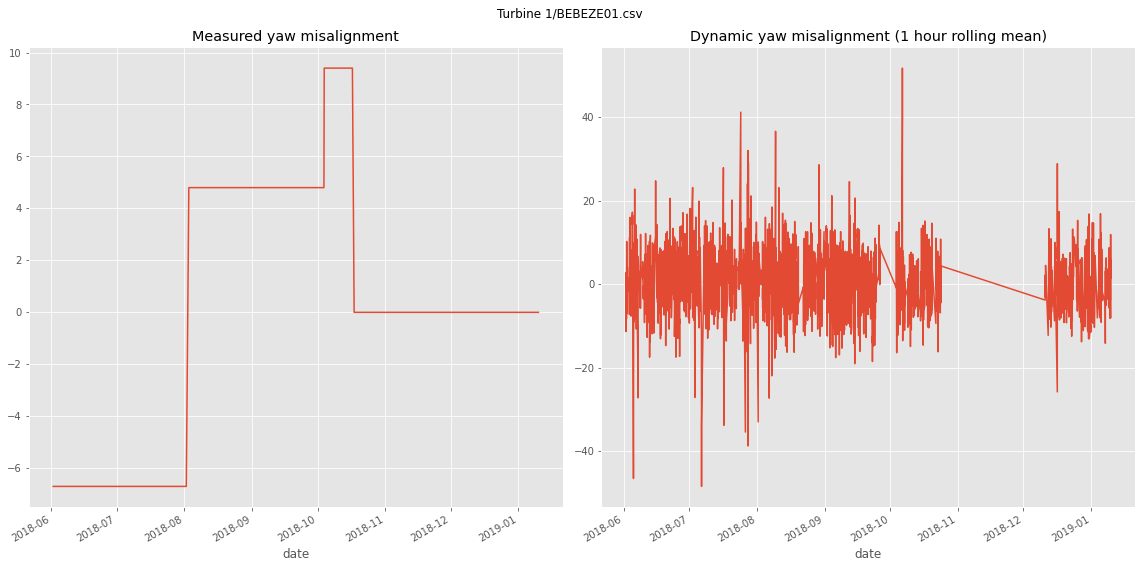

Static Yaw angles: [2.7, 2.7, 4.9, 0.0, 0.0]


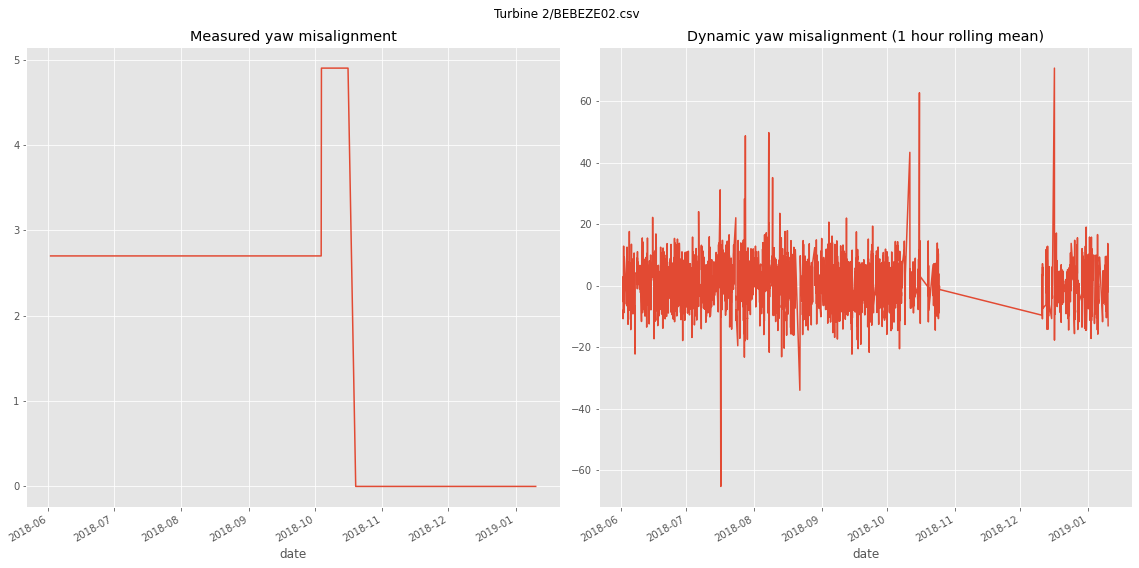

Static Yaw angles: [-2.2, 3.4, 7.5, 0.0, 0.0]


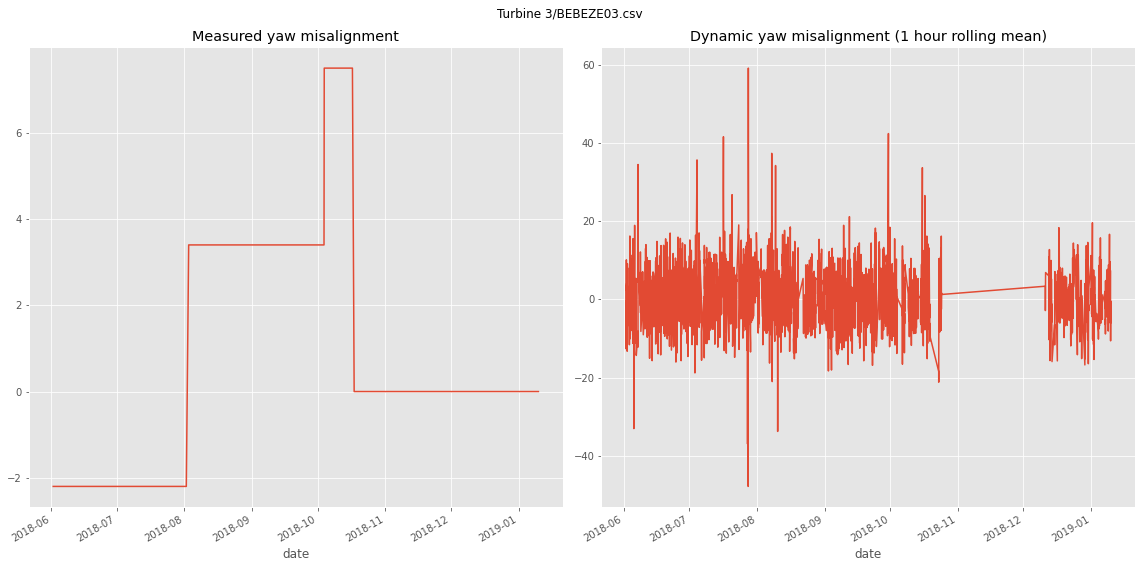

In [4]:
df_labels = pd.read_csv('/data/data2/panos/Yaw.csv')
df_angles_dict = {}
for i, t in enumerate(turbines):
    if t=='/data/data2/BBZ_10min_Scada/BEBEZE01.csv':
        df_l = df_labels[df_labels.Turbines == '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE01_scada_high_frequency.parquet']
    if t=='/data/data2/BBZ_10min_Scada/BEBEZE02.csv':
        df_l = df_labels[df_labels.Turbines == '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE02_scada_high_frequency.parquet']
    if t=='/data/data2/BBZ_10min_Scada/BEBEZE03.csv':
        df_l = df_labels[df_labels.Turbines == '/data/data2/engie_initial/post_treated_data/BEZ/BEBEZE03_scada_high_frequency.parquet']
    
    
    key = f"{i+1}/BEBEZE0{i+1}.csv"
    df_turbine = df_dict[key]
    df_turbine["y"] = np.nan
    df_turbine["perf"] = np.nan
    for start, end, static in zip(df_l.StartDate, df_l.EndDate, df_l.StaticYaw):
        df_turbine.loc[start:end, 'y'] = static
        if static == 0: 
            df_turbine.loc[start:end, 'perf'] = 1
        else:
            df_turbine.loc[start:end, 'perf'] = 0
            

    df_turbine = df_turbine.dropna()
    df_angles_dict[key] = list(df_l.StaticYaw.values)
    df_dict[key] = df_turbine
    print(f"Static Yaw angles: {df_angles_dict[key]}")
    fig, axs = plt.subplots(1, 2, figsize=(16, 8))
    plt.suptitle(f'Turbine {key}')

    ax1 = df_turbine['y'].plot(ax=axs[0])
    ax1.set_title(f"Measured yaw misalignment")

    ax2 = df_turbine['theta_d'].plot(ax=axs[1])
    ax2.set_title(f"Dynamic yaw misalignment (1 hour rolling mean)")
    plt.tight_layout()
    plt.show()
    

## Underperformance estimator
For each turbine, we apply a custom, unsupervised method, named UnderperformanceΕstimator, to classify points as to whether they correspond to underperforming behavior or not.

We fix target and feature variables, and the domain for each parameter used by our estimator. Target and feature variables imply dependence, i.e., the target variable (active power) must depend on the chosen feature variables. Our estimator implicitly uses this relation to model the power output when performance is optimal. The parameters' domains will be used for hyperparameter tuning. 

In [5]:
target = 'active power'
feats = ['wind speed',  'rotor speed']
#param_dict_est = {'params': [{'objective': 'quantile', 'metric': 'quantile', 'max_depth': 4, 'num_leaves': 30,'learning_rate': 0.1, 'n_estimators': 100, 'boosting_type': 'gbdt'}],
 #               'quantile': [0.9], 'segm_thsh': [0.2, 0.3, 0.4], 'chp_thsh': [0.7,0.8,0.9, 0.999]}
param_dict_est = {'params': [{'objective': 'quantile', 'metric': 'quantile', 'max_depth': 4, 'num_leaves': 30,'learning_rate': 0.1, 'n_estimators': 100, 'boosting_type': 'gbdt'}],
                'quantile': [0.9], 'segm_thsh': [0.2, 0.3, 0.4], 'chp_thsh': [0.8,0.9, 0.999]}    

The following scorer function will be used for hyperparameter tuning. It accesses our custom estimator's variables and computes a score indicating whether the two classes (good performance/underperformance) are well separated. 

In [6]:
def pipe_silhouette_scorer(pipe, X, y):
    estimator = pipe['estimator']
    labels = estimator.labels_
    scores = estimator.scores
    try:
        Sil = metrics.silhouette_samples(scores, labels)
        res = estimator.res.reshape(-1, 1)
        mask = labels == 1
        return np.mean(Sil)*np.mean(Sil[mask])
    except:
        return 0
    
    #return 0.5*(np.mean(Sil)+1)*int(np.sum(labels)/len(labels)>0.1)*int(np.sum(labels)/len(labels)<0.9)

For each turbine, we perform hyperparameter tuning of UnderperformanceΕstimator.

In [7]:
grid_labels = {}
grid_scores = {}
grid_params = {}
grid_res = {}
grid_chps = {}
for i, t in enumerate(turbines):
    key = f"{i+1}/BEBEZE0{i+1}.csv"
    df_train = df_dict[key]
    pipe = Pipeline([("estimator", UnderperformanceEstimator())])
    d2 = param_dict_est.copy()
    keys2 = list(d2.keys())
    for old_key in keys2:
        d2['estimator__' + old_key] = d2.pop(old_key)

    params_dict = {**d2}
    cv = [(slice(None), slice(None))]
    #pipe.fit(df_train[feats],df_train[[target]].values[:,0])
    grid = GridSearchCV(pipe, params_dict,  scoring = pipe_silhouette_scorer, cv = cv, n_jobs=-1, error_score = 'raise').fit(df_train[feats],df_train[[target]].values[:,0])
    #grid = RandomizedSearchCV(pipe, params_dict,  scoring = pipe_silhouette_scorer, cv = cv, n_jobs=-1, error_score = 'raise').fit(df_train[feats],df_train[[target]].values[:,0])
    grid_labels[key] =  grid.best_estimator_[0].labels_ 
    grid_res[key] = grid.best_estimator_[0].res
    grid_chps[key] = grid.best_estimator_[0].chps
    grid_scores[key] = grid.best_score_
    grid_params[key] = grid.best_params_
    



[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


We plot results, comparing predictions of our UnderperformanceEstimator with groundtruth labels 'perf'. We plot the static yaw angle, the labels obtained by UnderperformanceEstimator, and two elements of UnderperformanceEstimator, namely the residual curve which is an indicator how much the performance deviates from the optimal, and the  changepoints of the residual curve indicating a rapid change on the performance. 

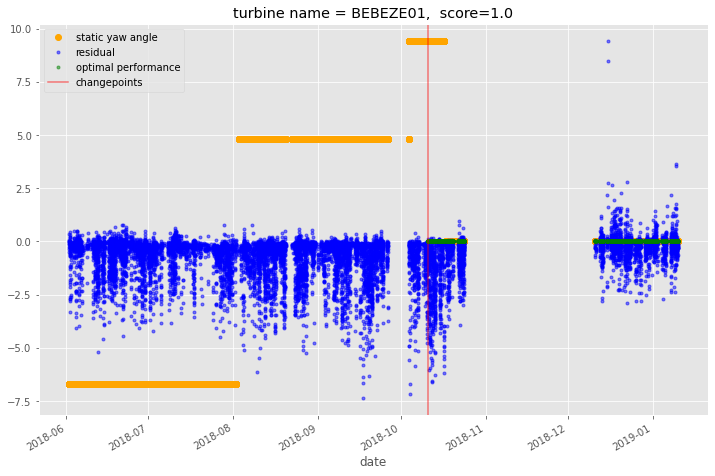

              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      8852
         1.0       0.81      1.00      0.89      2350

    accuracy                           0.95     11202
   macro avg       0.90      0.97      0.93     11202
weighted avg       0.96      0.95      0.95     11202



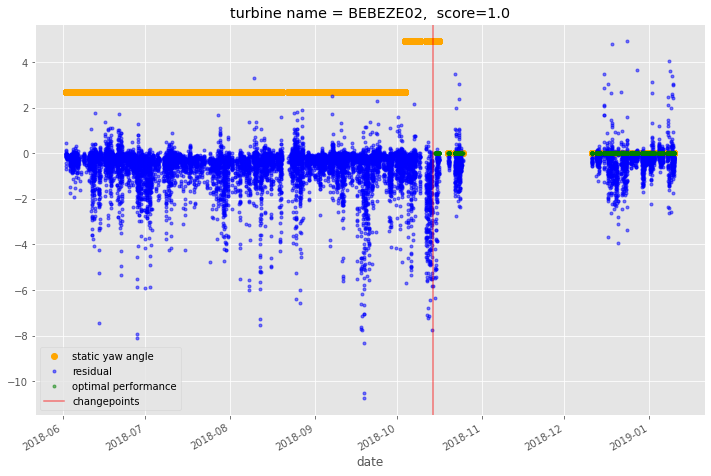

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9443
         1.0       0.94      1.00      0.97      1953

    accuracy                           0.99     11396
   macro avg       0.97      0.99      0.98     11396
weighted avg       0.99      0.99      0.99     11396



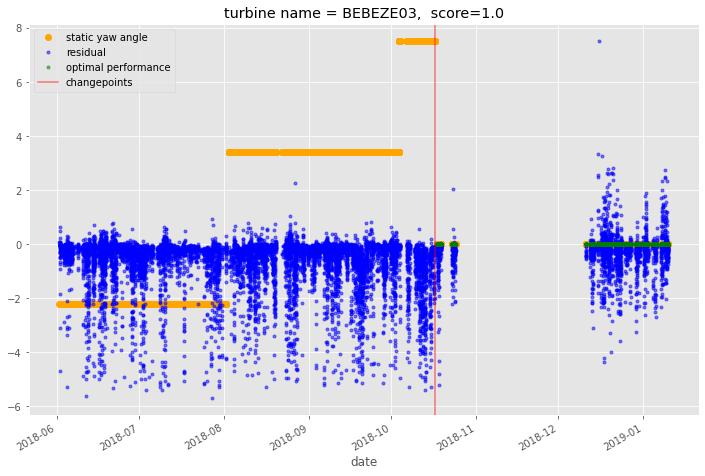

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      9689
         1.0       1.00      1.00      1.00      1988

    accuracy                           1.00     11677
   macro avg       1.00      1.00      1.00     11677
weighted avg       1.00      1.00      1.00     11677



In [8]:
for i, t in enumerate(turbines):
    s = set(range(3))
    key = f"{i+1}/BEBEZE0{i+1}.csv"
    df_train = df_dict[key]
    
    mask = grid_labels[key]==1
    res = pd.Series(grid_res[key], index = df_train.index)
    c = np.nanmax(res)/np.nanmax(df_train.y)
    (df_train.y).plot(color = 'orange', style = 'o',figsize=(12,8),label = 'static yaw angle')
    (res/c).plot(color = 'blue', style = '.', alpha = 0.5, label = 'residual')
    zeros=pd.Series(0,index=df_train.index)
    zeros[mask].plot(color = 'green', style = '.', alpha = 0.5, label = 'optimal performance')
    #plt.title(f'key = {key}, selector = {fs_name}, score={grid_scores[key+fs_name]}')
    for x in grid_chps[key]:
        plt.axvline(x, color = 'red', alpha = 0.5)
    plt.plot([], color = 'red', alpha = 0.5, label = 'changepoints')    
    plt.title(f'turbine name = BEBEZE0{i+1},  score={grid_scores[key]}')
    plt.legend()
    plt.show()
    print(classification_report(df_train.perf, grid_labels[key]))

## Testing on another turbine
We use the labels predicted by UnderperformanceEstimator to train a classifier. We test the classifier on a different turbine and we compare the results with the ground-truth 'perf'.

We perform feature selection and hyperparameter tuning on the classifier. Features are only selected from a set of five relevant columns. 

In [9]:
param_dict_est = {'max_depth': [4,8,16,32,64,128], 'num_leaves': [30,60,90,120,150,180,210,240],'learning_rate': [0.1, 0.2, 0.3, 0.4], 'n_estimators': [50,100, 200], 'boosting_type': ['gbdt']}

y_pred = {}
for i, t in enumerate(turbines):
    s = set(range(3))
    key_train = f"{i+1}/BEBEZE0{i+1}.csv"
    df_train = df_dict[key_train]
    #feats = df_train.columns
    s.discard(i)
    for fs_name, selector in FSConf.selectors_and_params.items():
            feats = ['wind speed', 'pitch angle', 'rotor speed', 'nacelle direction', 'wind direction']
            pipe = Pipeline([("selector", selector[0]()),
                             ("estimator", lgb.LGBMClassifier())])
            d1 = selector[1].copy()
            key_trains1 = list(d1.keys())
            for old_key_train in key_trains1:
                d1['selector__' + old_key_train] = d1.pop(old_key_train)

            d2 = param_dict_est.copy()
            key_trains2 = list(d2.keys())
            for old_key_train in key_trains2:
                d2['estimator__' + old_key_train] = d2.pop(old_key_train)

            params_dict = {**d1, **d2}
            cv = [(slice(None), slice(None))]
            labels =  grid_labels[key_train]
            grid = GridSearchCV(pipe, params_dict,  cv = cv, n_jobs=-1, error_score = 'raise').fit(df_train[feats], labels)
            #grid = RandomizedSearchCV(pipe, params_dict,  scoring = pipe_silhouette_scorer, cv = cv, n_jobs=-1, error_score = 'raise').fit(df_train[feats],df_train[[target]].values[:,0])
            
            y_pr = grid.predict(df_train[feats])
            print(key_train+fs_name)
            print(classification_report(df_train.perf, y_pr))
            
            for j in s:
                key_test = f"{j+1}/BEBEZE0{j+1}.csv"
                df_test = df_dict[key_test]
                y_pred[key_train+fs_name+key_test] = grid.predict(df_test[feats])
                #print(classification_report(df_test.perf, y_pred[key_train+fs_name+key_test]))
                



1/BEBEZE01.csvSelectPercentileR
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      8852
         1.0       0.81      1.00      0.89      2350

    accuracy                           0.95     11202
   macro avg       0.90      0.97      0.93     11202
weighted avg       0.96      0.95      0.95     11202

1/BEBEZE01.csvSelectPercentileMI
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      8852
         1.0       0.81      1.00      0.89      2350

    accuracy                           0.95     11202
   macro avg       0.90      0.97      0.93     11202
weighted avg       0.96      0.95      0.95     11202

2/BEBEZE02.csvSelectPercentileR
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      9443
         1.0       0.94      1.00      0.97      1953

    accuracy                           0.99     11396
   macro avg       0.97      0.

### Plot results

For each combinatio of training/testing turbines, and each one of feature selectors used, we plot the static yaw angle and the labels returned by the classifier, along with metrics regarding accuracy. 

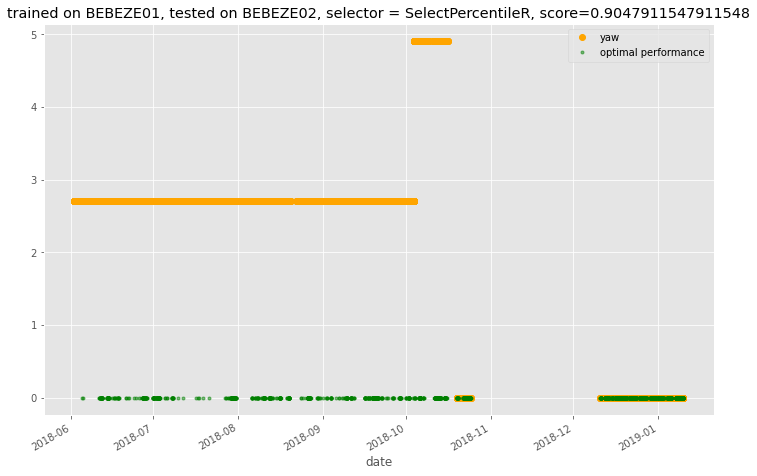

trained on BEBEZE01, tested on BEBEZE02, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      9443
         1.0       0.66      0.92      0.77      1953

    accuracy                           0.90     11396
   macro avg       0.82      0.91      0.85     11396
weighted avg       0.93      0.90      0.91     11396



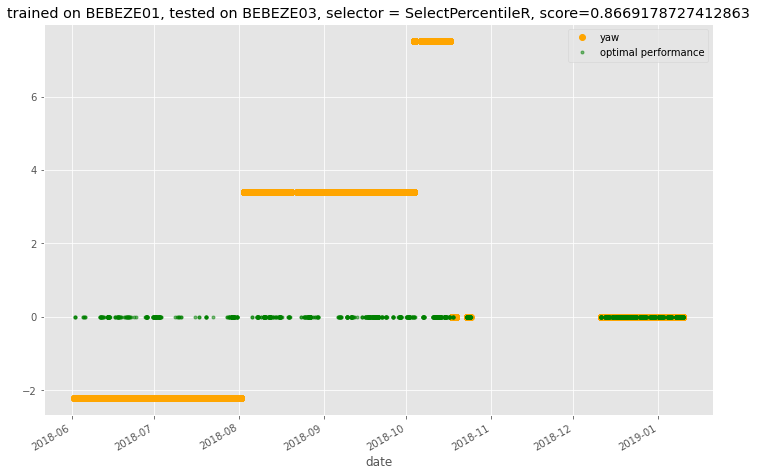

trained on BEBEZE01, tested on BEBEZE03, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      9689
         1.0       0.59      0.74      0.66      1988

    accuracy                           0.87     11677
   macro avg       0.77      0.82      0.79     11677
weighted avg       0.88      0.87      0.87     11677



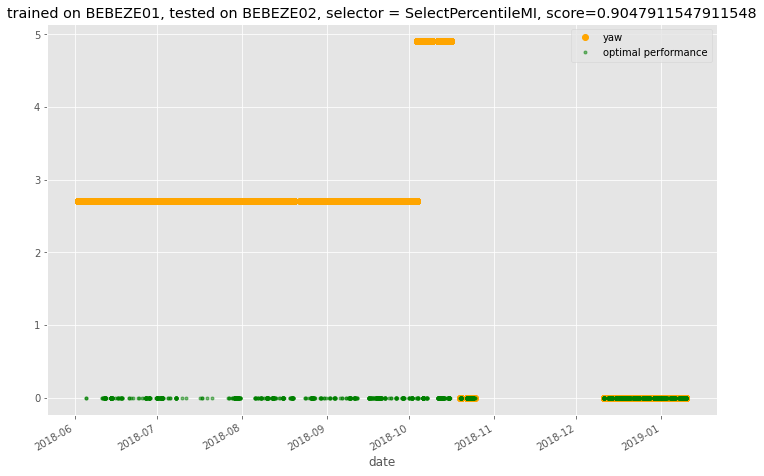

trained on BEBEZE01, tested on BEBEZE02, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      9443
         1.0       0.66      0.92      0.77      1953

    accuracy                           0.90     11396
   macro avg       0.82      0.91      0.85     11396
weighted avg       0.93      0.90      0.91     11396



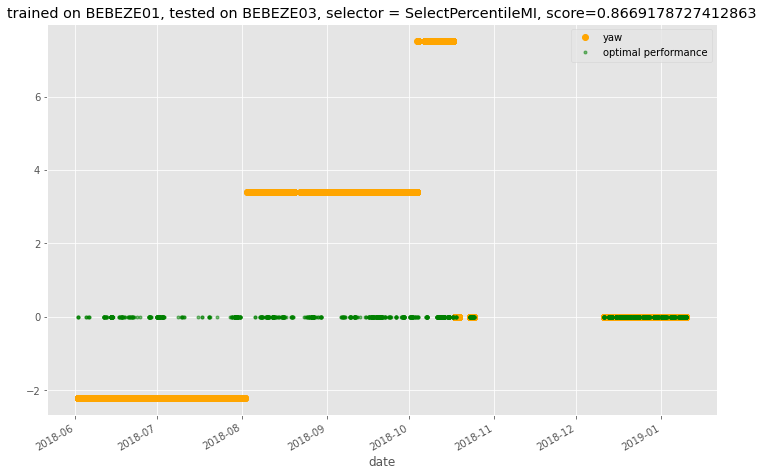

trained on BEBEZE01, tested on BEBEZE03, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92      9689
         1.0       0.59      0.74      0.66      1988

    accuracy                           0.87     11677
   macro avg       0.77      0.82      0.79     11677
weighted avg       0.88      0.87      0.87     11677



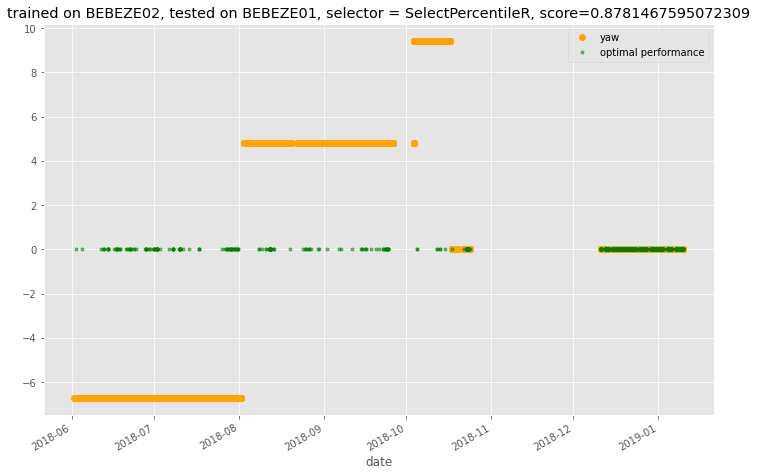

trained on BEBEZE02, tested on BEBEZE01, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      8852
         1.0       0.87      0.49      0.63      2350

    accuracy                           0.88     11202
   macro avg       0.87      0.74      0.78     11202
weighted avg       0.88      0.88      0.86     11202



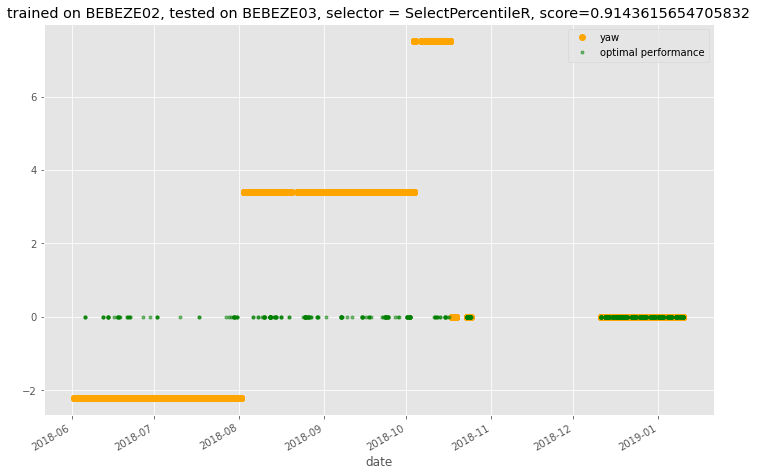

trained on BEBEZE02, tested on BEBEZE03, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      9689
         1.0       0.85      0.61      0.71      1988

    accuracy                           0.91     11677
   macro avg       0.89      0.79      0.83     11677
weighted avg       0.91      0.91      0.91     11677



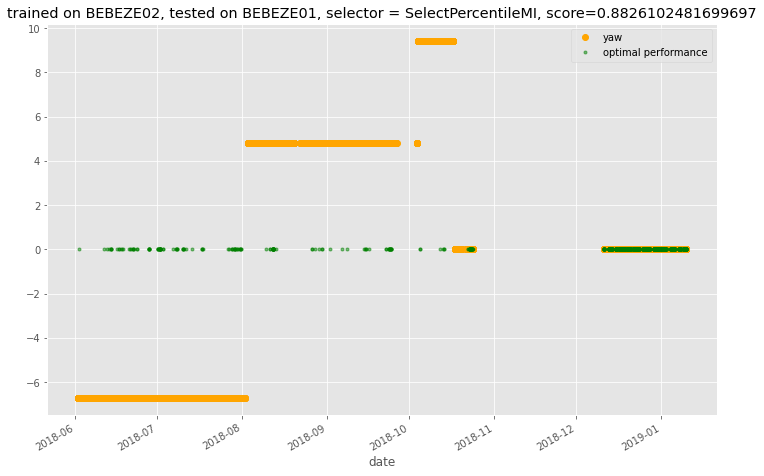

trained on BEBEZE02, tested on BEBEZE01, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93      8852
         1.0       0.90      0.50      0.64      2350

    accuracy                           0.88     11202
   macro avg       0.89      0.74      0.79     11202
weighted avg       0.88      0.88      0.87     11202



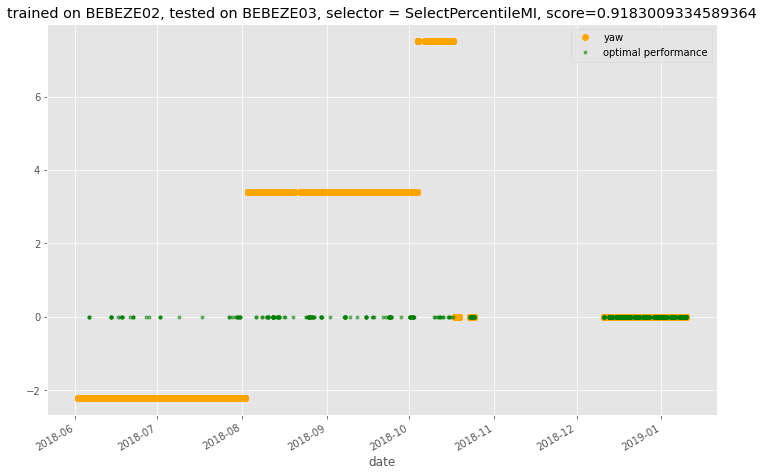

trained on BEBEZE02, tested on BEBEZE03, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95      9689
         1.0       0.87      0.61      0.72      1988

    accuracy                           0.92     11677
   macro avg       0.90      0.80      0.84     11677
weighted avg       0.92      0.92      0.91     11677



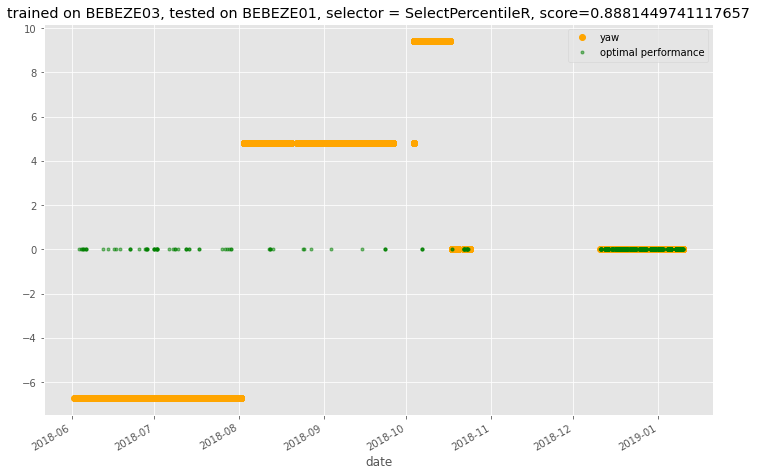

trained on BEBEZE03, tested on BEBEZE01, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      8852
         1.0       0.94      0.50      0.65      2350

    accuracy                           0.89     11202
   macro avg       0.91      0.74      0.79     11202
weighted avg       0.89      0.89      0.87     11202



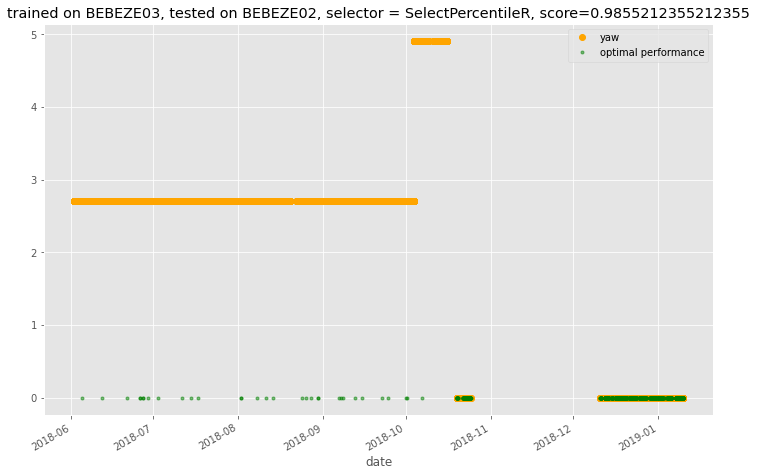

trained on BEBEZE03, tested on BEBEZE02, selector = SelectPercentileR
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9443
         1.0       0.98      0.93      0.96      1953

    accuracy                           0.99     11396
   macro avg       0.98      0.96      0.97     11396
weighted avg       0.99      0.99      0.99     11396



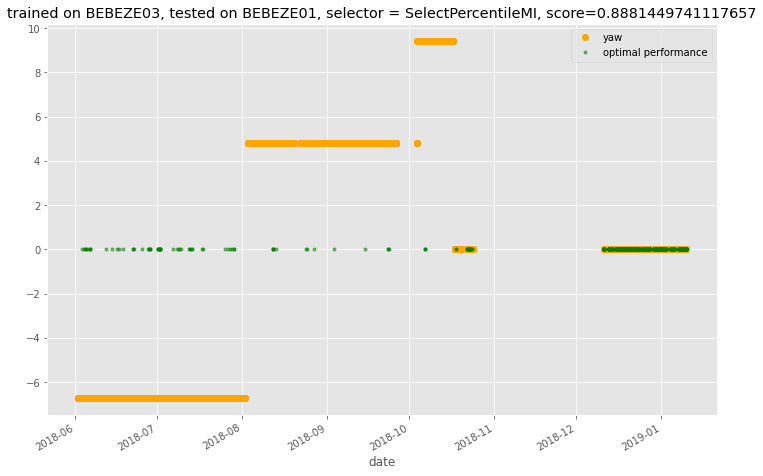

trained on BEBEZE03, tested on BEBEZE01, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      8852
         1.0       0.94      0.50      0.65      2350

    accuracy                           0.89     11202
   macro avg       0.91      0.74      0.79     11202
weighted avg       0.89      0.89      0.87     11202



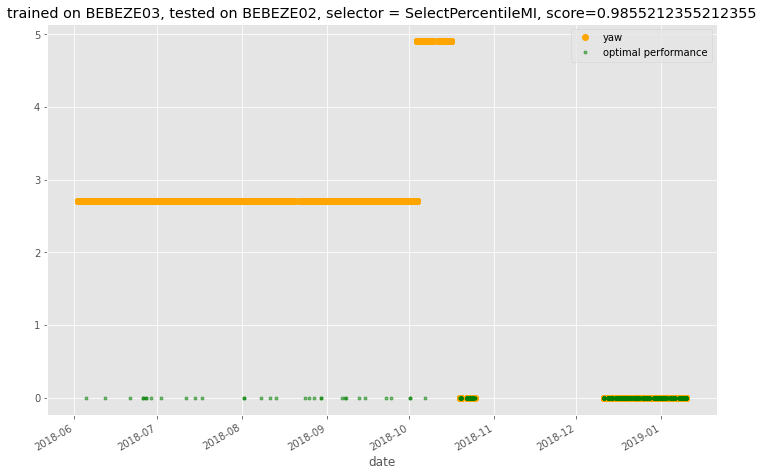

trained on BEBEZE03, tested on BEBEZE02, selector = SelectPercentileMI
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      9443
         1.0       0.98      0.93      0.96      1953

    accuracy                           0.99     11396
   macro avg       0.98      0.96      0.97     11396
weighted avg       0.99      0.99      0.99     11396

[1 1 1 ... 1 1 1]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1 1 1 ... 1 1 1]
[0 0 0 ... 0 0 0]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0 0 0 ... 0 0 0]
[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[0 0 0 ... 0 0 0]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipsarros/more_venv2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]
[1 1 1 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [10]:
for i, t in enumerate(turbines):
    s = set(range(3))
    key_train = f"{i+1}/BEBEZE0{i+1}.csv"
    df_train = df_dict[key_train]
    s.discard(i)
    for fs_name, selector in FSConf.selectors_and_params.items():
        for j in s:
                key_test = f"{j+1}/BEBEZE0{j+1}.csv"
                df_test = df_dict[key_test]
                mask = y_pred[key_train+fs_name+key_test]==1
                (df_test.y).plot(color = 'orange', style = 'o',figsize=(12,8),label = 'yaw')
                zeros=pd.Series(0,index=df_test.index)
                zeros[mask].plot(color = 'green', style = '.', alpha = 0.5, label = 'optimal performance')
                #plt.title(f'key = {key}, selector = {fs_name}, score={grid_scores[key+fs_name]}')
                plt.title(f'trained on BEBEZE0{i+1}, tested on BEBEZE0{j+1}, selector = {fs_name}, score={accuracy_score(df_test.perf, y_pred[key_train+fs_name+key_test])}')
                plt.legend()
                plt.show()
                print(f'trained on BEBEZE0{i+1}, tested on BEBEZE0{j+1}, selector = {fs_name}')
                print(classification_report(df_test.perf, y_pred[key_train+fs_name+key_test]))